In [12]:
import gzip
import json
import logging
import os
import requests
import yaml
import csv
import numpy as np
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_contracts(date, quote_type):
    url = 'https://hist-quote.1tokentrade.cn/{}/contracts?date={}'.format(quote_type, date)
    print('get contracts: ', url)
    r = requests.get(url, timeout=5)
    if r.status_code != 200:
        print('fail get contracts', r.status_code, r.text)
    print('----------available contracts------------')
    print('total size', len(r.json()))
    print('first 10 contracts', r.json()[:10])
    return r.json()


In [3]:
all_contracts = np.array(get_contracts("2020-05-06", 'ticks'))

get contracts:  https://hist-quote.1tokentrade.cn/ticks/contracts?date=2020-05-06
----------available contracts------------
total size 5801
first 10 contracts ['a365mex/btc.usd.td', 'basefex/bch.btc.td', 'basefex/bnb.btc.td', 'basefex/btc.usd.td', 'basefex/btc.usdt.td', 'basefex/dash.usdt.td', 'basefex/eos.usdt.td', 'basefex/etc.usdt.td', 'basefex/eth.btc.td', 'basefex/eth.usdt.td']


In [4]:
all_contracts

array(['a365mex/btc.usd.td', 'basefex/bch.btc.td', 'basefex/bnb.btc.td',
       ..., 'zb/zrx.btc', 'zb/zrx.qc', 'zb/zrx.usdt'], dtype='<U37')

In [5]:
exchange_list= np.array(list(map(lambda x: x[0:x.index("/")], all_contracts)))
np.unique(exchange_list)

array(['a365mex', 'basefex', 'binance', 'binancef', 'bitbank', 'bitfinex',
       'bitflyer', 'bitflyex', 'bithumb', 'bitmax', 'bitmex', 'bitstamp',
       'bittrex', 'bitz', 'bitzf', 'btcbox', 'bybit', 'coinbase',
       'coinbeneswap', 'coincheck', 'coinone', 'crypto', 'deribit',
       'ftxf', 'gaea', 'gaef', 'gate', 'gemini', 'gopax', 'hcoin', 'hoo',
       'huobif', 'huobip', 'huobiswap', 'itbit', 'korbit', 'kraken',
       'kucoin', 'kumex', 'lbank', 'mxc', 'okef', 'okex', 'okswap',
       'poloniex', 'qume', 'quoinex', 'rightbtc', 'upbit', 'zb'],
      dtype='<U12')

In [6]:
chosen = np.where(exchange_list=='huobiswap')
all_contracts[chosen]

array(['huobiswap/ada.usd.td', 'huobiswap/bch.usd.td',
       'huobiswap/bsv.usd.td', 'huobiswap/btc.usd.td',
       'huobiswap/dash.usd.td', 'huobiswap/eos.usd.td',
       'huobiswap/etc.usd.td', 'huobiswap/eth.usd.td',
       'huobiswap/link.usd.td', 'huobiswap/ltc.usd.td',
       'huobiswap/trx.usd.td', 'huobiswap/xrp.usd.td',
       'huobiswap/zec.usd.td'], dtype='<U37')

In [7]:
all_contracts[chosen]

array(['huobiswap/ada.usd.td', 'huobiswap/bch.usd.td',
       'huobiswap/bsv.usd.td', 'huobiswap/btc.usd.td',
       'huobiswap/dash.usd.td', 'huobiswap/eos.usd.td',
       'huobiswap/etc.usd.td', 'huobiswap/eth.usd.td',
       'huobiswap/link.usd.td', 'huobiswap/ltc.usd.td',
       'huobiswap/trx.usd.td', 'huobiswap/xrp.usd.td',
       'huobiswap/zec.usd.td'], dtype='<U37')

In [8]:
def download(url, file_path):
    print('downloading', url)
    r = requests.get(url, headers={'ot-key': ot_key}, stream=True)
    if r.status_code != 200:
        print('fail get historical data', r.status_code, r.text)
        print('failed ot-key', ot_key[:5], ot_key[-5:], len(ot_key))
        return
    print('quota-remaining:', r.headers.get('ot-quota-remaining'),
          'quota-consumption:', r.headers.get('ot-quota-consumption'))
    block_size = 300 * 1024
    total = 0
    with open(file_path, 'wb') as f:
        for data in r.iter_content(block_size):
            f.write(data)
            total += len(data) / 1024
            #print('downloaded {}kb'.format(round(total)))

In [9]:
def download_full_ticks(contract, date, file_path):
    url = 'https://hist-quote.1tokentrade.cn/ticks/full?date={}&contract={}'.format(date, contract)
    download(url, file_path)


In [10]:
def down_load_contract_full_tick(contract, start_date, end_date,path="e:/1token"):
    format_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    day = timedelta(days=1)
    cur_date = start_date
    all_dates = []
    while cur_date<end_date:
        all_dates.append(cur_date)
        format_date = format_date+day
        cur_date = format_date.strftime("%Y-%m-%d")
    for date in all_dates:
        file_path = path+'/tick-full-{}-{}.gz'.format(date, contract.replace('/', '-'))
        download_full_ticks(contract, date , file_path)

In [14]:
ot_key = '' ## enter your own key of 1token

In [15]:
down_load_contract_full_tick("huobiswap/btc.usd.td", "2020-05-06", "2020-05-07")

downloading https://hist-quote.1tokentrade.cn/ticks/full?date=2020-05-06&contract=huobiswap/btc.usd.td
quota-remaining: 12394 quota-consumption: 100


In [16]:
path = "e:/1token"
contract_name = "huobiswap-btc.usd.td"
date = "2020-05-06"
file_name = path+"/tick-full-"+date+"-"+contract_name+".gz"
g_file = gzip.GzipFile(file_name)
output_dire = "e:"
output_name = output_dire+"/"+contract_name+"-"+date+".csv"
open(output_name, "wb+").write(g_file.read())
g_file.close()

In [17]:
data = pd.read_csv(output_name)
data[:10]

,time,last,volume,ask_0_p,ask_0_v,ask_1_p,ask_1_v,ask_2_p,ask_2_v,ask_3_p,...,bid_15_v,bid_16_p,bid_16_v,bid_17_p,bid_17_v,bid_18_p,bid_18_v,bid_19_p,bid_19_v,timestamp
0,2020-05-06T00:00:00.440623Z,9026.1,1,9026.1,2604,9026.5,1,9026.6,13,9026.8,...,54,9023.3,503,9023.2,290,9023.0,22,9022.9,1,1588723200440
1,2020-05-06T00:00:00.946112Z,9026.1,0,9026.1,1934,9026.5,1,9026.6,13,9026.8,...,54,9023.3,503,9023.2,252,9023.0,22,9022.9,1,1588723200946
2,2020-05-06T00:00:01.456087Z,9026.1,0,9026.1,2034,9026.5,1,9026.6,13,9026.8,...,200,9023.4,54,9023.3,495,9023.2,252,9023.0,22,1588723201456
3,2020-05-06T00:00:01.977380Z,9026.0,5,9026.1,2529,9026.5,1,9026.6,13,9026.8,...,68,9023.3,495,9023.2,252,9023.0,22,9022.8,22,1588723201977
4,2020-05-06T00:00:02.487149Z,9026.0,119,9026.1,5358,9026.5,1,9026.6,13,9026.8,...,14,9023.3,495,9023.2,252,9022.8,22,9022.7,6,1588723202487
5,2020-05-06T00:00:02.994853Z,9026.0,0,9026.1,5262,9026.5,1,9026.6,13,9026.8,...,505,9023.2,252,9022.8,22,9022.7,6,9022.6,700,1588723202994
6,2020-05-06T00:00:03.505479Z,9026.0,100,9026.1,2122,9026.5,1,9026.6,13,9026.8,...,495,9023.2,252,9023.0,40,9022.9,50,9022.8,22,1588723203505
7,2020-05-06T00:00:04.015421Z,9026.0,564,9026.1,4008,9026.5,1,9026.6,13,9026.7,...,495,9023.2,252,9023.0,11,9022.9,50,9022.8,42,1588723204015
8,2020-05-06T00:00:04.516161Z,9026.1,10,9026.1,3575,9026.5,2,9026.6,13,9026.7,...,52,9023.3,495,9023.2,252,9023.0,11,9022.9,50,1588723204516
9,2020-05-06T00:00:05.026929Z,9026.1,0,9026.1,5395,9026.5,2,9026.6,13,9026.7,...,52,9023.3,495,9023.2,252,9023.0,11,9022.9,50,1588723205026


In [18]:
data.columns

Index(['time', 'last', 'volume', 'ask_0_p', 'ask_0_v', 'ask_1_p', 'ask_1_v',
       'ask_2_p', 'ask_2_v', 'ask_3_p', 'ask_3_v', 'ask_4_p', 'ask_4_v',
       'ask_5_p', 'ask_5_v', 'ask_6_p', 'ask_6_v', 'ask_7_p', 'ask_7_v',
       'ask_8_p', 'ask_8_v', 'ask_9_p', 'ask_9_v', 'ask_10_p', 'ask_10_v',
       'ask_11_p', 'ask_11_v', 'ask_12_p', 'ask_12_v', 'ask_13_p', 'ask_13_v',
       'ask_14_p', 'ask_14_v', 'ask_15_p', 'ask_15_v', 'ask_16_p', 'ask_16_v',
       'ask_17_p', 'ask_17_v', 'ask_18_p', 'ask_18_v', 'ask_19_p', 'ask_19_v',
       'bid_0_p', 'bid_0_v', 'bid_1_p', 'bid_1_v', 'bid_2_p', 'bid_2_v',
       'bid_3_p', 'bid_3_v', 'bid_4_p', 'bid_4_v', 'bid_5_p', 'bid_5_v',
       'bid_6_p', 'bid_6_v', 'bid_7_p', 'bid_7_v', 'bid_8_p', 'bid_8_v',
       'bid_9_p', 'bid_9_v', 'bid_10_p', 'bid_10_v', 'bid_11_p', 'bid_11_v',
       'bid_12_p', 'bid_12_v', 'bid_13_p', 'bid_13_v', 'bid_14_p', 'bid_14_v',
       'bid_15_p', 'bid_15_v', 'bid_16_p', 'bid_16_v', 'bid_17_p', 'bid_17_v',
       'bid

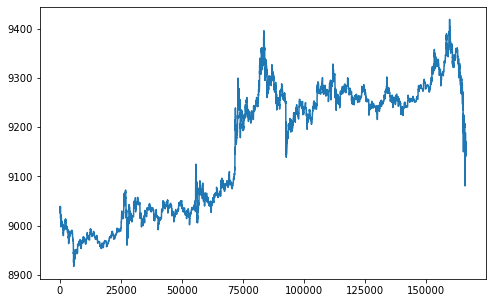

In [19]:
plt.figure(1, figsize=(8, 5));
plt.plot(data["last"]);